In [1]:
import pandas as pd
import regex as re
import numpy as np

from sklearn.model_selection import train_test_split

import ahocorasick

import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration, AutoTokenizer, MT5ForConditionalGeneration, get_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW, lr_scheduler

from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
SEP_TOKEN = '▁<extra_id_0>'
INPUT_PREFIX = ''

In [3]:
df = pd.read_json ('train_t1_v1.jsonl', lines = True)
df.drop (columns = ['id', 'keywords'], inplace = True)
print (df.head ())

                                                text  \
0  ABBYY Retrieval & Morphology Engine\nВ сообщен...   
1  Речевые формулы в диалоге\nПредложенная класси...   
2  Географические названия и полнотекстовые докум...   
3  Методы автоматического построения специализиро...   
4  Закономерности построения дискурсивной последо...   

                                               label  
0  [[0, 35], [6, 15], [18, 35], [29, 35], [69, 88...  
1  [[0, 15], [18, 25], [74, 99], [134, 140], [175...  
2  [[0, 23], [26, 50], [54, 68], [169, 190], [181...  
3  [[7, 63], [34, 63], [54, 63], [92, 128], [119,...  
4  [[26, 57], [62, 76], [251, 265], [266, 280], [...  


In [ ]:
def split_text (text, segments, delimiters = ['...', '.', '?!', '?', '!']):

    delimiters_pattern = '|'.join (map (re.escape, delimiters))
    
    paragraphs = re.split (f'(?<=\n[ ]*)', text)
    
    sentences_with_segments = []
    
    current_start_index = 0

    for paragraph in paragraphs:

        sentences = re.split (f'(?<=[{delimiters_pattern}] )(?=[A-ZА-ЯЁ])', paragraph)#.strip ())

        for sentence in sentences:

            start_index = current_start_index
            end_index = start_index + len (sentence)

            matched_segments = [
                text [start: end] for start, end in segments if start >= start_index and end <= end_index
            ]
            sentences_with_segments.append ((sentence, matched_segments))

            current_start_index = end_index
    
    return sentences_with_segments

In [ ]:
first_train_data_txt, second_train_data_txt, first_train_labels_txt, second_train_labels_txt = train_test_split (df ['text'], df ['label'], test_size = 0.5, random_state = 14)

In [6]:
def label_constructor (labels):
    res = []
    for label in labels:
        one_label = []
        for start, end, cls in label:
            one_label.append ([start, end])
        res.append (one_label)
    return res

In [7]:
df_2 = pd.read_json ('./test_data/test1_t12_full_v2.jsonl', lines = True)
df_2 = df_2 [['text', 'label']]
print (df_2.head ())

                                                text  \
0  АВТОМАТИЧЕСКИЙ АНАЛИЗ ТОНАЛЬНОСТИ ТЕКСТОВ НА О...   
1  InBASE: ТЕХНОЛОГИЯ ПОСТРОЕНИЯ ЕЯ-ИНТЕРФЕЙСОВ К...   
2  Выражение уважительности с помощью личных мест...   
3  ДА ЧЕРТ ЛИ В ДЕТАЛЯХ?.. МЕРА ДЛЯ ОЦЕНКИ СОВПАД...   
4  КОРПУСНАЯ ОЦЕНКА СОЧЕТАЕМОСТИ СЛОВ С ИСПОЛЬЗОВ...   

                                               label  
0  [[0, 33, specific], [22, 33, specific], [52, 7...  
1  [[0, 6, nomen], [19, 44, specific], [30, 44, s...  
2  [[0, 24, specific], [35, 53, specific], [42, 5...  
3  [[51, 70, specific], [61, 70, specific], [116,...  
4  [[0, 16, specific], [17, 34, specific], [30, 3...  


In [ ]:
val_data_txt, val_labels_txt, test_data_txt, test_labels_txt = train_test_split (df_2 ['text'], df_2 ['label'], test_size = 0.5, random_state = 14)

In [ ]:
def create_parallels (data_lst, labels_lst):
    parallel_text = []
    parallel_label = []
    for i in range (len (data_lst)):
        text = data_lst [i]
        segments = labels_lst [i]
        splitted = split_text (text, segments)
        for sentence, terms in splitted:
            parallel_text.append (INPUT_PREFIX + sentence)
            constructed_label = ''
            for term in terms:
                constructed_label += term.strip () + SEP_TOKEN
            if len (constructed_label) > 0:
                parallel_label.append (constructed_label [: - len (SEP_TOKEN)])
            else:
                parallel_label.append ('')
    return parallel_text, parallel_label

first_train_data_lst = first_train_data_txt.tolist ()
first_train_labels_lst = first_train_labels_txt.tolist ()
first_parallel_text, first_parallel_labels = create_parallels (first_train_data_lst, first_train_labels_lst)

second_train_data_lst = second_train_data_txt.tolist ()
second_train_labels_lst = second_train_labels_txt.tolist ()
second_parallel_text, second_parallel_labels = create_parallels (second_train_data_lst, second_train_labels_lst)

val_data_lst = val_data_txt.tolist ()
val_labels_lst = label_constructor (val_labels_txt)
val_parallel_text, val_parallel_labels = create_parallels (val_data_lst, val_labels_lst)

test_data_lst = test_data_txt.tolist ()
test_labels_lst = label_constructor (test_labels_txt)
test_parallel_text, test_parallel_labels = create_parallels (test_data_lst, test_labels_lst)

In [10]:
all_train_terms = set ()

for line in parallel_label:
    
    all_train_terms |= set (line.split (SEP_TOKEN))

all_train_terms -= set ([''])
len (all_train_terms)

9761

In [11]:
def one_finder (text, phrases):

    if len (phrases) == 1 and '' in phrases:
        return []

    A = ahocorasick.Automaton ()
    
    for idx, phrase in enumerate (phrases):
        A.add_word (phrase, (idx, phrase))
    
    A.make_automaton ()
    
    found = []
    for end_index, (idx, phrase) in A.iter (text):
        start_index = end_index - len (phrase) + 1

        if start_index > 0 and text [start_index - 1].isalpha ():
            continue
        if end_index + 1 < len (text) and text [end_index + 1].isalpha ():
            continue

        found.append ((start_index, end_index + 1, phrase))
    
    return found

In [12]:

np.random.seed (14)

def extract_n_phrases (s: str, n: int):
    words = s.split () # questionable
    phrases_list = []
    for length in range (1, n + 1):
        for i in range (len (words) - length + 1):
            phrase = ' '.join (words [i: i + length])
            phrases_list.append (phrase)
    return phrases_list

ATTACHMENT_TOKEN = '▁<extra_id_1>'
def make_attachment (text, dictionary_terms = all_train_terms):
    found = one_finder (text, dictionary_terms)
    found_terms = [item [2] for item in found]
    res = text + ATTACHMENT_TOKEN
    for term in found_terms:
        res += term + SEP_TOKEN
    if len (found_terms) > 0:
        res = res [: - len (SEP_TOKEN)]
    return res

def make_random_attachment (text, dictionary_terms = all_train_terms):
    found = one_finder (text, dictionary_terms)
    found_terms = [item [2] for item in found]
    n_phrases = extract_n_phrases (text, n = 3)
    res = text + ATTACHMENT_TOKEN
    for term in found_terms:
        if np.random.choice ([True, False], p = [0.65, 0.35]):
            res += term + SEP_TOKEN
        else:
            res += np.random.choice (n_phrases) + SEP_TOKEN
    if len (found_terms) > 0:
        res = res [: - len (SEP_TOKEN)]
    return res

def attach_dictionary_foundings (texts, dictionary_terms = all_train_terms, use_random = False):
    res_texts = []
    for text in tqdm (texts):
        if use_random:
            res_texts.append (make_random_attachment (text, dictionary_terms))
        else:
            res_texts.append (make_attachment (text, dictionary_terms))
    return res_texts

### WHAT?
'''
i = 0
half_train_terms = set ()
for item in all_train_terms:
    if i % 2 == 0:
        half_train_terms |= set ([item])
    i += 1
'''

parallel_text_new = attach_dictionary_foundings (parallel_text, all_train_terms, use_random = True)
parallel_text_val_new = attach_dictionary_foundings (parallel_text_val, all_train_terms)
parallel_text_test_new = attach_dictionary_foundings (parallel_text_test, all_train_terms)

100%|██████████| 1290/1290 [00:14<00:00, 89.13it/s]


In [13]:
parallel_text_new [1]

'В сообщении представляется новый программный продукт, относящийся к классу “engines”, то есть, предоставляющий пользователю некоторые технологии не в составе прикладных программных продуктов, а в “чистом” виде. ▁<extra_id_1>программный продукт▁<extra_id_0>engines▁<extra_id_0>пользователю▁<extra_id_0>прикладных программных продуктов▁<extra_id_0>программных продуктов'

In [14]:
USED_MODEL_NAME = 'cointegrated/rut5-small' #'cointegrated/rut5-base'#

SEQ_MAX_LENGTH = 300
ANSWER_MAX_LENGTH = 170
BATCH_SIZE = 16
EVAL_BATCH_SIZE = 16

ENABLE_LABEL_FIX = True

In [15]:
tokenizer = AutoTokenizer.from_pretrained (USED_MODEL_NAME)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
c:\Users\Enfi\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


(array([1.537e+03, 2.604e+03, 1.541e+03, 7.040e+02, 2.570e+02, 7.900e+01,
        2.400e+01, 1.300e+01, 3.000e+00, 2.000e+00]),
 array([  3. ,  35.6,  68.2, 100.8, 133.4, 166. , 198.6, 231.2, 263.8,
        296.4, 329. ]),
 <BarContainer object of 10 artists>)

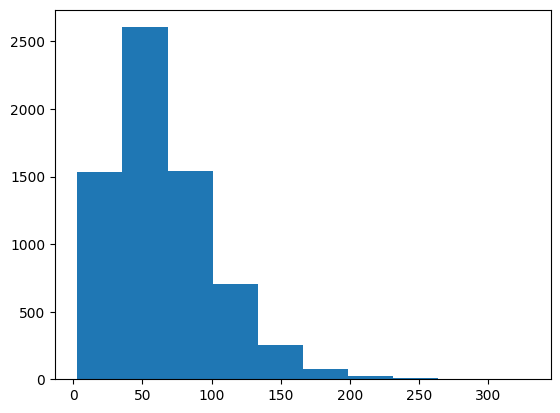

In [16]:

lengths = []

tknz = tokenizer (parallel_text_new)
for tnsr in tknz ['input_ids']:
    lengths.append (len (tnsr))

tknz = tokenizer (parallel_text_val_new)
for tnsr in tknz ['input_ids']:
    lengths.append (len (tnsr))

tknz = tokenizer (parallel_text_test_new)
for tnsr in tknz ['input_ids']:
    lengths.append (len (tnsr))

plt.hist (lengths)

In [17]:
max (lengths)

329

In [18]:
train_data = tokenizer (parallel_text_new, padding = 'max_length', truncation = True, max_length = SEQ_MAX_LENGTH, return_tensors = 'pt')
#train_labels = tokenizer (parallel_label, padding = 'max_length', truncation = True, max_length = SEQ_MAX_LENGTH, return_tensors = 'pt')
train_labels = tokenizer (parallel_label, padding = 'max_length', truncation = True, max_length = ANSWER_MAX_LENGTH, return_tensors = 'pt')

val_data = tokenizer (parallel_text_val_new, padding = 'max_length', truncation = True, max_length = SEQ_MAX_LENGTH, return_tensors = 'pt')
#val_labels = tokenizer (parallel_label_val, padding = 'max_length', truncation = True, max_length = SEQ_MAX_LENGTH, return_tensors = 'pt')
val_labels = tokenizer (parallel_label_val, padding = 'max_length', truncation = True, max_length = ANSWER_MAX_LENGTH, return_tensors = 'pt')

test_data = tokenizer (parallel_text_test_new, padding = 'max_length', truncation = True, max_length = SEQ_MAX_LENGTH, return_tensors = 'pt')
#test_labels = tokenizer (parallel_label_test, padding = 'max_length', truncation = True, max_length = SEQ_MAX_LENGTH, return_tensors = 'pt')
test_labels = tokenizer (parallel_label_test, padding = 'max_length', truncation = True, max_length = ANSWER_MAX_LENGTH, return_tensors = 'pt')

In [19]:
### EXPERIMENTAL SOMETHING

def replace_padding (labels):
    for i in range (0, len (labels ['input_ids'])):
        labels ['input_ids'] [i] = torch.tensor ([labl if labl != 0 else - 100 for labl in labels ['input_ids'] [i]])

    return labels

if ENABLE_LABEL_FIX:
    rse = replace_padding (train_labels)
    train_labels = rse

    rse = replace_padding (val_labels)
    val_labels = rse

    rse = replace_padding (test_labels)
    test_labels = rse

train_labels ['input_ids']
###

tensor([[  298,   452,   452,  ...,  -100,  -100,  -100],
        [ 6527,  1626,  6414,  ...,  -100,  -100,  -100],
        [ 7592, 17096,  5446,  ...,  -100,  -100,  -100],
        ...,
        [ 9102,   685, 20099,  ...,  -100,  -100,  -100],
        [ 9102,   685, 20099,  ...,  -100,  -100,  -100],
        [ 5416,  7368,   685,  ...,  -100,  -100,  -100]])

In [20]:
class Seq2SeqDataset (Dataset):
    def __init__ (self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__ (self, idx):
        return {
            'input_ids': self.encodings ['input_ids'] [idx],
            'attention_mask': self.encodings ['attention_mask'] [idx],
            'labels': self.labels ['input_ids'] [idx]
        }

    def __len__ (self):
        return len (self.encodings ['input_ids'])

train_dataset = Seq2SeqDataset (train_data, train_labels)
val_dataset = Seq2SeqDataset (val_data, val_labels)
test_dataset = Seq2SeqDataset (test_data, test_labels)

train_loader = DataLoader (train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader (val_dataset, batch_size = EVAL_BATCH_SIZE)
test_loader = DataLoader (test_dataset, batch_size = EVAL_BATCH_SIZE)

In [21]:
device = torch.device ('cuda' if torch.cuda.is_available () else 'cpu')

model = MT5ForConditionalGeneration.from_pretrained (USED_MODEL_NAME)

model.to (device)
print (model.device)
#model.train ()


cuda:0


In [22]:
def get_set (tensor, ground_truth = True, tokenizer = tokenizer):

    separator: str
    if SEP_TOKEN == '▁<extra_id_0>': separator = '<extra_id_0>'
    else: separator = SEP_TOKEN

    res: set

    if ground_truth:
        eos_idx = (tensor == 1).nonzero ()
        if eos_idx.numel () > 0:
            eos_idx = int (eos_idx [0] [0])
        else:
            eos_idx = len (tensor)
        seq = tensor [:eos_idx]
    
    else:
        seq = tensor [tensor != 0]
        seq = seq [seq != - 100]   ### WHAT?!
        seq = seq [seq != 1]
    
    txt = tokenizer.decode (seq)
    res = set ([item.strip () for item in txt.split (separator)])

    if len (res) > 1:
        res -= set ([''])

    return res


def sanity_check (preds, labels, to_print = False):

    tps_sum = 0
    fps_sum = 0
    fns_sum = 0 

    for i in range (len (labels)):
        predicted_set = get_set (preds [i], ground_truth = False)
        true_set = get_set (labels [i])

        if to_print: print (f'True: {true_set}\nPred: {predicted_set}')

        tps_sum += len (true_set & predicted_set)  # Истинно положительные
        fps_sum += len (predicted_set - true_set)     # Ложноположительные
        fns_sum += len (true_set - predicted_set)     # Ложноотрицательные

    precision = tps_sum / (tps_sum + fps_sum) if (tps_sum + fps_sum) > 0 else 0
    recall = tps_sum / (tps_sum + fns_sum) if (tps_sum + fns_sum) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1_score

In [23]:
metrics = {'train_loss': [], 'val_loss': [], 'precision': [], 'recall': [], 'f1_score': []}

In [24]:
'''
random_train_texts = []
iterations = 100
for epoch in range (iterations):
    print (f'Train for epoch {epoch + 1} / {iterations}:')
    random_train_texts.append (attach_dictionary_foundings (parallel_text, all_train_terms, use_random = True))
'''
random_train_save = pd.read_json ('random_train_texts_v1.json')
random_train_texts = random_train_save ['text']


In [25]:
num_epochs = 100
training_steps = len (train_data ['input_ids']) // BATCH_SIZE * num_epochs
warmup_steps = int (training_steps * 0.1)
print (f'Suggested train steps: {training_steps}\n\t warmup steps: {int (training_steps * 0.05)} - {int (training_steps * 0.1)}')

Suggested train steps: 26100
	 warmup steps: 1305 - 2610


In [26]:
#from fairseq.optim.adafactor import Adafactor

In [27]:
#optimizer = AdamW (model.parameters (), lr = 1e-5)#, weight_decay = 0.05)
optimizer = AdamW (filter (lambda p: p.requires_grad, model.parameters ()), lr = 3e-5, weight_decay = 0.02)

#optimizer = Adafactor (model.parameters (), lr = 3e-5, scale_parameter = False, relative_step = False, weight_decay = 0.02)

#scheduler = lr_scheduler.StepLR (optimizer, warmup_steps = 637, training_steps = 6375)
scheduler = get_scheduler ('linear', optimizer = optimizer, num_warmup_steps = warmup_steps, num_training_steps = training_steps)

In [28]:
for epoch in range (num_epochs):
    model.train ()  # Устанавливаем модель в режим обучения
    total_loss = 0

    ###
    train_data = tokenizer (random_train_texts [epoch], padding = 'max_length', truncation = True, max_length = SEQ_MAX_LENGTH, return_tensors = 'pt')
    train_dataset = Seq2SeqDataset (train_data, train_labels)
    train_loader = DataLoader (train_dataset, batch_size = BATCH_SIZE, shuffle = True)
    ###
    
    for batch in tqdm (train_loader):
        
        input_ids = batch ['input_ids'].to (model.device)
        attention_mask = batch ['attention_mask'].to (model.device)
        labels = batch ['labels'].to (model.device)

        outputs = model (input_ids = input_ids, attention_mask = attention_mask, labels = labels)
        loss = outputs.loss   ## DOUBLE CHECK if padding ...
        total_loss += loss.item ()

        loss.backward ()  # Обратное распространение
        optimizer.step ()  # Обновление параметров
        optimizer.zero_grad ()  # Обнуляем градиенты

        scheduler.step ()  # Обновление learning rate
        torch.cuda.empty_cache ()
    

    avg_loss = total_loss / len (train_loader)

    metrics ['train_loss'].append ((epoch, avg_loss))

    # Оценка на валидационной выборке
    model.eval ()  # Устанавливаем модель в режим оценки
    val_preds, val_labels = [], []
    total_val_loss = 0

    with torch.no_grad ():
        for batch in val_loader:
            input_ids = batch ['input_ids'].to (model.device)
            attention_mask = batch ['attention_mask'].to (model.device)
            labels = batch ['labels'].to (model.device)

            outputs = model.generate (input_ids = input_ids, attention_mask = attention_mask)

            total_val_loss += model (input_ids = input_ids, attention_mask = attention_mask, labels = labels).loss.item ()

            val_preds.extend (outputs)
            val_labels.extend (labels)
            torch.cuda.empty_cache ()

    avg_val_loss = total_val_loss / len (val_loader)

    prec, recl, f1sc = sanity_check (val_preds, val_labels)

    metrics ['val_loss'].append ((epoch, avg_val_loss))
    metrics ['precision'].append ((epoch, prec))
    metrics ['recall'].append ((epoch, recl))
    metrics ['f1_score'].append ((epoch, f1sc))

    print (f'Epoch {epoch + 1} / {num_epochs}, Loss: {avg_loss:.4f}, Validation loss: {avg_val_loss:.4f}, {prec} / {recl} / {f1sc}')

100%|██████████| 262/262 [01:39<00:00,  2.64it/s]


Epoch 1 / 100, Loss: 3.1801, Validation loss: 3.0151, 0.0007751937984496124 / 0.00019932230416583617 / 0.0003171079752655779


100%|██████████| 262/262 [01:35<00:00,  2.74it/s]


Epoch 2 / 100, Loss: 2.3831, Validation loss: 2.2146, 0.10166358595194085 / 0.03288818018736297 / 0.0496987951807229


100%|██████████| 262/262 [01:35<00:00,  2.75it/s]


Epoch 3 / 100, Loss: 1.8366, Validation loss: 1.7503, 0.3455357142857143 / 0.1542754634243572 / 0.21331128565522944


100%|██████████| 262/262 [01:35<00:00,  2.75it/s]


Epoch 4 / 100, Loss: 1.4584, Validation loss: 1.3560, 0.4513888888888889 / 0.24616304564480765 / 0.31858635366954724


100%|██████████| 262/262 [01:34<00:00,  2.76it/s]


Epoch 5 / 100, Loss: 1.1294, Validation loss: 1.0861, 0.48775510204081635 / 0.28582818417380906 / 0.3604373507603368


100%|██████████| 262/262 [01:35<00:00,  2.76it/s]


Epoch 6 / 100, Loss: 0.9484, Validation loss: 0.9623, 0.5107913669064749 / 0.3113414391070361 / 0.3868730650154799


100%|██████████| 262/262 [01:34<00:00,  2.76it/s]


Epoch 7 / 100, Loss: 0.8401, Validation loss: 0.8696, 0.5277777777777778 / 0.32569264500697626 / 0.4028103044496487


100%|██████████| 262/262 [01:35<00:00,  2.76it/s]


Epoch 8 / 100, Loss: 0.7470, Validation loss: 0.7857, 0.5455417066155321 / 0.34024317321108233 / 0.41910139945985764


100%|██████████| 262/262 [01:35<00:00,  2.75it/s]


Epoch 9 / 100, Loss: 0.6803, Validation loss: 0.7270, 0.5850234009360374 / 0.3737293203109428 / 0.4560934079299441


100%|██████████| 262/262 [01:35<00:00,  2.75it/s]


Epoch 10 / 100, Loss: 0.6221, Validation loss: 0.7097, 0.6086112010359339 / 0.374725931831772 / 0.463853935356526


100%|██████████| 262/262 [01:35<00:00,  2.74it/s]


Epoch 11 / 100, Loss: 0.5760, Validation loss: 0.6659, 0.6092026473369051 / 0.3852900139525613 / 0.472039072039072


100%|██████████| 262/262 [01:35<00:00,  2.76it/s]


Epoch 12 / 100, Loss: 0.5299, Validation loss: 0.6424, 0.6272095959595959 / 0.39605341837751645 / 0.48552229688454485


100%|██████████| 262/262 [01:35<00:00,  2.76it/s]


Epoch 13 / 100, Loss: 0.4923, Validation loss: 0.6251, 0.6267409470752089 / 0.4036276659358182 / 0.49102812803103785


100%|██████████| 262/262 [01:35<00:00,  2.76it/s]


Epoch 14 / 100, Loss: 0.4681, Validation loss: 0.6116, 0.6442189421894219 / 0.41758022722742677 / 0.5067118152134479


100%|██████████| 262/262 [01:35<00:00,  2.76it/s]


Epoch 15 / 100, Loss: 0.4456, Validation loss: 0.6204, 0.6657259328943242 / 0.42316125174407015 / 0.517426273458445


100%|██████████| 262/262 [01:34<00:00,  2.76it/s]


Epoch 16 / 100, Loss: 0.4295, Validation loss: 0.5955, 0.6566523605150214 / 0.42694837552322107 / 0.5174537987679672


100%|██████████| 262/262 [01:34<00:00,  2.76it/s]


Epoch 17 / 100, Loss: 0.4116, Validation loss: 0.5964, 0.6702988792029888 / 0.42914092086904526 / 0.5232713573945802


100%|██████████| 262/262 [01:35<00:00,  2.76it/s]


Epoch 18 / 100, Loss: 0.3929, Validation loss: 0.5840, 0.666056166056166 / 0.4349212676898545 / 0.5262269383817678


100%|██████████| 262/262 [01:34<00:00,  2.76it/s]


Epoch 19 / 100, Loss: 0.3793, Validation loss: 0.5869, 0.6671802773497689 / 0.43153278851903526 / 0.5240861776809489


100%|██████████| 262/262 [01:35<00:00,  2.76it/s]


Epoch 20 / 100, Loss: 0.3668, Validation loss: 0.5653, 0.6674684305472038 / 0.4424955152481563 / 0.5321826681049983


100%|██████████| 262/262 [01:37<00:00,  2.69it/s]


Epoch 21 / 100, Loss: 0.3548, Validation loss: 0.5854, 0.675 / 0.4359178792106837 / 0.5297323483105245


100%|██████████| 262/262 [01:45<00:00,  2.47it/s]


Epoch 22 / 100, Loss: 0.3432, Validation loss: 0.5912, 0.684863523573201 / 0.4401036475981662 / 0.5358572988714962


100%|██████████| 262/262 [01:45<00:00,  2.48it/s]


Epoch 23 / 100, Loss: 0.3288, Validation loss: 0.5675, 0.6857749469214437 / 0.4506677297189556 / 0.5439018522973299


100%|██████████| 262/262 [01:44<00:00,  2.51it/s]


Epoch 24 / 100, Loss: 0.3224, Validation loss: 0.5692, 0.6955855303494789 / 0.45226230815228224 / 0.5481338325884768


100%|██████████| 262/262 [01:43<00:00,  2.52it/s]


Epoch 25 / 100, Loss: 0.3139, Validation loss: 0.5606, 0.687863038826047 / 0.44847518437313133 / 0.542953667953668


100%|██████████| 262/262 [01:43<00:00,  2.53it/s]


Epoch 26 / 100, Loss: 0.3064, Validation loss: 0.5730, 0.7015063018751921 / 0.4548534981064381 / 0.5518742442563483


100%|██████████| 262/262 [01:44<00:00,  2.52it/s]


Epoch 27 / 100, Loss: 0.2982, Validation loss: 0.5701, 0.6997541487400123 / 0.4538568865856089 / 0.5505984766050054


100%|██████████| 262/262 [01:44<00:00,  2.50it/s]


Epoch 28 / 100, Loss: 0.2885, Validation loss: 0.5911, 0.7105508870214753 / 0.45505282041060396 / 0.5547995139732685


100%|██████████| 262/262 [01:44<00:00,  2.50it/s]


Epoch 29 / 100, Loss: 0.2827, Validation loss: 0.5715, 0.6997261940979617 / 0.45844129958142316 / 0.5539499036608863


100%|██████████| 262/262 [01:44<00:00,  2.52it/s]


Epoch 30 / 100, Loss: 0.2786, Validation loss: 0.5775, 0.7026123936816525 / 0.461032489535579 / 0.5567456974365146


100%|██████████| 262/262 [01:43<00:00,  2.53it/s]


Epoch 31 / 100, Loss: 0.2697, Validation loss: 0.5735, 0.699488105992171 / 0.4630257125772374 / 0.5572079635404174


100%|██████████| 262/262 [01:44<00:00,  2.51it/s]


Epoch 32 / 100, Loss: 0.2636, Validation loss: 0.5800, 0.7120563035495716 / 0.46382300179390074 / 0.5617380808690404


100%|██████████| 262/262 [01:44<00:00,  2.50it/s]


Epoch 33 / 100, Loss: 0.2560, Validation loss: 0.5772, 0.7034104750304506 / 0.46043452262308154 / 0.5565594506685942


100%|██████████| 262/262 [01:43<00:00,  2.53it/s]


Epoch 34 / 100, Loss: 0.2526, Validation loss: 0.5809, 0.7045871559633028 / 0.4592385887980865 / 0.5560516471581995


100%|██████████| 262/262 [01:40<00:00,  2.60it/s]


Epoch 35 / 100, Loss: 0.2462, Validation loss: 0.5923, 0.7086783195338853 / 0.46063384492724735 / 0.5583474269147137


100%|██████████| 262/262 [01:35<00:00,  2.75it/s]


Epoch 36 / 100, Loss: 0.2407, Validation loss: 0.5901, 0.7028272894898586 / 0.4558501096272673 / 0.5530165638979567


100%|██████████| 262/262 [01:35<00:00,  2.75it/s]


Epoch 37 / 100, Loss: 0.2394, Validation loss: 0.5895, 0.7125693160813309 / 0.461032489535579 / 0.5598450925813869


100%|██████████| 262/262 [01:35<00:00,  2.75it/s]


Epoch 38 / 100, Loss: 0.2341, Validation loss: 0.5766, 0.7080801944106926 / 0.46462029101056407 / 0.561078348778433


100%|██████████| 262/262 [01:34<00:00,  2.76it/s]


Epoch 39 / 100, Loss: 0.2291, Validation loss: 0.5925, 0.7153035935563816 / 0.4602352003189157 / 0.5600970285021225


100%|██████████| 262/262 [01:37<00:00,  2.69it/s]


Epoch 40 / 100, Loss: 0.2317, Validation loss: 0.5699, 0.7000301477238469 / 0.46282639027307154 / 0.5572354211663066


100%|██████████| 262/262 [01:46<00:00,  2.46it/s]


Epoch 41 / 100, Loss: 0.2210, Validation loss: 0.5779, 0.7006658595641646 / 0.4614311341439107 / 0.5564235067900493


100%|██████████| 262/262 [01:44<00:00,  2.50it/s]


Epoch 42 / 100, Loss: 0.2199, Validation loss: 0.5878, 0.7072266831377394 / 0.4564480765397648 / 0.5548152634766808


100%|██████████| 262/262 [01:45<00:00,  2.49it/s]


Epoch 43 / 100, Loss: 0.2124, Validation loss: 0.5961, 0.7023086269744836 / 0.4608331672314132 / 0.5565049945841859


100%|██████████| 262/262 [01:44<00:00,  2.51it/s]


Epoch 44 / 100, Loss: 0.2082, Validation loss: 0.5974, 0.7118279569892473 / 0.4618297787522424 / 0.5602030947775629


100%|██████████| 262/262 [01:44<00:00,  2.51it/s]


Epoch 45 / 100, Loss: 0.2071, Validation loss: 0.5933, 0.7079101261926747 / 0.45844129958142316 / 0.5564964916525527


100%|██████████| 262/262 [01:43<00:00,  2.53it/s]


Epoch 46 / 100, Loss: 0.2066, Validation loss: 0.5901, 0.7101096224116931 / 0.46481961331472993 / 0.561860016865438


100%|██████████| 262/262 [01:46<00:00,  2.46it/s]


Epoch 47 / 100, Loss: 0.2007, Validation loss: 0.5914, 0.7036247334754797 / 0.46043452262308154 / 0.5566265060240965


100%|██████████| 262/262 [01:44<00:00,  2.51it/s]


Epoch 48 / 100, Loss: 0.1984, Validation loss: 0.5940, 0.7043451838347007 / 0.4620291010564082 / 0.5580163697640828


100%|██████████| 262/262 [01:45<00:00,  2.48it/s]


Epoch 49 / 100, Loss: 0.1940, Validation loss: 0.6024, 0.7156048014773777 / 0.46342435718556907 / 0.5625453665618195


100%|██████████| 262/262 [01:45<00:00,  2.48it/s]


Epoch 50 / 100, Loss: 0.1944, Validation loss: 0.6057, 0.7114320835894284 / 0.4614311341439107 / 0.5597872083182203


100%|██████████| 262/262 [01:44<00:00,  2.51it/s]


Epoch 51 / 100, Loss: 0.1872, Validation loss: 0.6003, 0.7146363915311446 / 0.4642216464022324 / 0.5628322861285646


100%|██████████| 262/262 [01:44<00:00,  2.50it/s]


Epoch 52 / 100, Loss: 0.1882, Validation loss: 0.6017, 0.7167950693374422 / 0.4636236794897349 / 0.5630597918179616


100%|██████████| 262/262 [01:46<00:00,  2.46it/s]


Epoch 53 / 100, Loss: 0.1834, Validation loss: 0.6043, 0.710703363914373 / 0.4632250348814032 / 0.5608784843731145


100%|██████████| 262/262 [01:52<00:00,  2.33it/s]


Epoch 54 / 100, Loss: 0.1836, Validation loss: 0.5966, 0.7114854517611026 / 0.4630257125772374 / 0.5609756097560976


100%|██████████| 262/262 [01:45<00:00,  2.48it/s]


Epoch 55 / 100, Loss: 0.1821, Validation loss: 0.6076, 0.7097665847665847 / 0.46063384492724735 / 0.5586848785204884


100%|██████████| 262/262 [01:46<00:00,  2.46it/s]


Epoch 56 / 100, Loss: 0.1761, Validation loss: 0.6063, 0.7113684852179214 / 0.4652182579230616 / 0.5625451916124368


100%|██████████| 262/262 [01:45<00:00,  2.49it/s]


Epoch 57 / 100, Loss: 0.1752, Validation loss: 0.6087, 0.7114443084455324 / 0.46342435718556907 / 0.5612552806276403


100%|██████████| 262/262 [01:46<00:00,  2.47it/s]


Epoch 58 / 100, Loss: 0.1781, Validation loss: 0.6258, 0.719629057187017 / 0.4640223240980666 / 0.5642268540959767


100%|██████████| 262/262 [01:44<00:00,  2.51it/s]


Epoch 59 / 100, Loss: 0.1728, Validation loss: 0.6036, 0.7092349893325206 / 0.46382300179390074 / 0.5608580380814654


100%|██████████| 262/262 [01:43<00:00,  2.52it/s]


Epoch 60 / 100, Loss: 0.1707, Validation loss: 0.6048, 0.7156441717791411 / 0.46501893561889573 / 0.5637308203455359


100%|██████████| 262/262 [01:44<00:00,  2.51it/s]


Epoch 61 / 100, Loss: 0.1719, Validation loss: 0.6130, 0.7177048174286591 / 0.4662148694438908 / 0.5652489125181247


100%|██████████| 262/262 [01:44<00:00,  2.51it/s]


Epoch 62 / 100, Loss: 0.1659, Validation loss: 0.6128, 0.7177518427518428 / 0.4658162248355591 / 0.5649703855916839


100%|██████████| 262/262 [01:44<00:00,  2.51it/s]


Epoch 63 / 100, Loss: 0.1641, Validation loss: 0.6160, 0.7180981595092024 / 0.46661351405222246 / 0.5656638878820829


100%|██████████| 262/262 [01:44<00:00,  2.51it/s]


Epoch 64 / 100, Loss: 0.1618, Validation loss: 0.6217, 0.7177819083023544 / 0.4618297787522424 / 0.5620375985445726


100%|██████████| 262/262 [01:49<00:00,  2.40it/s]


Epoch 65 / 100, Loss: 0.1631, Validation loss: 0.6228, 0.7214373464373465 / 0.4682080924855491 / 0.5678713888553124


100%|██████████| 262/262 [01:53<00:00,  2.32it/s]


Epoch 66 / 100, Loss: 0.1593, Validation loss: 0.6183, 0.7229916897506925 / 0.4682080924855491 / 0.5683522864747156


100%|██████████| 262/262 [02:14<00:00,  1.95it/s]


Epoch 67 / 100, Loss: 0.1592, Validation loss: 0.6280, 0.7237569060773481 / 0.47000199322304165 / 0.5699093655589124


100%|██████████| 262/262 [01:50<00:00,  2.38it/s]


Epoch 68 / 100, Loss: 0.1564, Validation loss: 0.6279, 0.7225985221674877 / 0.46780944787721745 / 0.5679370840895342


100%|██████████| 262/262 [01:52<00:00,  2.34it/s]


Epoch 69 / 100, Loss: 0.1588, Validation loss: 0.6262, 0.7252848783492455 / 0.4694040263105442 / 0.5699419167473379


100%|██████████| 262/262 [01:47<00:00,  2.44it/s]


Epoch 70 / 100, Loss: 0.1540, Validation loss: 0.6165, 0.7224953902888752 / 0.4686067370938808 / 0.5684923225728449


100%|██████████| 262/262 [02:20<00:00,  1.86it/s]


Epoch 71 / 100, Loss: 0.1513, Validation loss: 0.6182, 0.7201344332416743 / 0.46980267091887584 / 0.568636911942099


100%|██████████| 262/262 [01:49<00:00,  2.40it/s]


Epoch 72 / 100, Loss: 0.1515, Validation loss: 0.6210, 0.7225964482547459 / 0.4704006378313733 / 0.5698418447422431


100%|██████████| 262/262 [01:48<00:00,  2.41it/s]


Epoch 73 / 100, Loss: 0.1483, Validation loss: 0.6348, 0.7291217257318953 / 0.47159657165636837 / 0.5727426773178408


100%|██████████| 262/262 [01:51<00:00,  2.35it/s]


Epoch 74 / 100, Loss: 0.1493, Validation loss: 0.6266, 0.7245619428220105 / 0.46980267091887584 / 0.570012091898428


100%|██████████| 262/262 [01:49<00:00,  2.40it/s]


Epoch 75 / 100, Loss: 0.1479, Validation loss: 0.6223, 0.7253758821724455 / 0.4711979270480367 / 0.5712904784920251


100%|██████████| 262/262 [01:49<00:00,  2.39it/s]


Epoch 76 / 100, Loss: 0.1466, Validation loss: 0.6293, 0.7209800918836141 / 0.4692047040063783 / 0.5684617242212026


100%|██████████| 262/262 [01:57<00:00,  2.22it/s]


Epoch 77 / 100, Loss: 0.1450, Validation loss: 0.6365, 0.7267119062307218 / 0.46960334861471 / 0.5705291197481536


100%|██████████| 262/262 [01:52<00:00,  2.32it/s]


Epoch 78 / 100, Loss: 0.1434, Validation loss: 0.6234, 0.724211815120906 / 0.47159657165636837 / 0.5712216320618059


100%|██████████| 262/262 [01:54<00:00,  2.29it/s]


Epoch 79 / 100, Loss: 0.1446, Validation loss: 0.6317, 0.7262159681859895 / 0.47319115008969503 / 0.5730147236302195


100%|██████████| 262/262 [01:51<00:00,  2.36it/s]


Epoch 80 / 100, Loss: 0.1436, Validation loss: 0.6288, 0.7253585596582239 / 0.47378911700219256 / 0.5731854352544008


100%|██████████| 262/262 [01:47<00:00,  2.44it/s]


Epoch 81 / 100, Loss: 0.1423, Validation loss: 0.6292, 0.7245801526717557 / 0.4729918277855292 / 0.5723589001447177


100%|██████████| 262/262 [01:49<00:00,  2.39it/s]


Epoch 82 / 100, Loss: 0.1429, Validation loss: 0.6375, 0.7233128834355829 / 0.47000199322304165 / 0.5697716563972454


100%|██████████| 262/262 [01:51<00:00,  2.34it/s]


Epoch 83 / 100, Loss: 0.1395, Validation loss: 0.6411, 0.7228729963008631 / 0.4674108032688858 / 0.567727877980874


100%|██████████| 262/262 [01:51<00:00,  2.36it/s]


Epoch 84 / 100, Loss: 0.1381, Validation loss: 0.6338, 0.7234432234432234 / 0.4723938608730317 / 0.5715663812854215


100%|██████████| 262/262 [01:38<00:00,  2.66it/s]


Epoch 85 / 100, Loss: 0.1414, Validation loss: 0.6384, 0.7218989280245023 / 0.46980267091887584 / 0.569186186911374


100%|██████████| 262/262 [01:35<00:00,  2.75it/s]


Epoch 86 / 100, Loss: 0.1380, Validation loss: 0.6428, 0.7209444955535111 / 0.4686067370938808 / 0.5680115970041073


100%|██████████| 262/262 [01:38<00:00,  2.66it/s]


Epoch 87 / 100, Loss: 0.1417, Validation loss: 0.6369, 0.7208804646896974 / 0.47000199322304165 / 0.569015444015444


100%|██████████| 262/262 [01:41<00:00,  2.57it/s]


Epoch 88 / 100, Loss: 0.1389, Validation loss: 0.6453, 0.7217444717444718 / 0.468407414789715 / 0.5681131391272816


100%|██████████| 262/262 [01:44<00:00,  2.50it/s]


Epoch 89 / 100, Loss: 0.1358, Validation loss: 0.6383, 0.7233128834355829 / 0.47000199322304165 / 0.5697716563972454


100%|██████████| 262/262 [01:41<00:00,  2.59it/s]


Epoch 90 / 100, Loss: 0.1366, Validation loss: 0.6425, 0.7257072570725708 / 0.4704006378313733 / 0.5708066271616883


100%|██████████| 262/262 [01:41<00:00,  2.59it/s]


Epoch 91 / 100, Loss: 0.1359, Validation loss: 0.6360, 0.7231569287243805 / 0.4711979270480367 / 0.5706010137581463


100%|██████████| 262/262 [01:39<00:00,  2.63it/s]


Epoch 92 / 100, Loss: 0.1381, Validation loss: 0.6368, 0.723175965665236 / 0.4702013155272075 / 0.5698755888392318


100%|██████████| 262/262 [01:44<00:00,  2.52it/s]


Epoch 93 / 100, Loss: 0.1411, Validation loss: 0.6366, 0.7243176939589083 / 0.470799282439705 / 0.5706692437786905


100%|██████████| 262/262 [01:43<00:00,  2.53it/s]


Epoch 94 / 100, Loss: 0.1370, Validation loss: 0.6404, 0.7255985267034991 / 0.4711979270480367 / 0.5713595166163142


100%|██████████| 262/262 [01:43<00:00,  2.53it/s]


Epoch 95 / 100, Loss: 0.1381, Validation loss: 0.6372, 0.7246554364471669 / 0.47159657165636837 / 0.5713595749818884


100%|██████████| 262/262 [01:39<00:00,  2.64it/s]


Epoch 96 / 100, Loss: 0.1335, Validation loss: 0.6425, 0.7239471257300953 / 0.4694040263105442 / 0.569528415961306


100%|██████████| 262/262 [01:35<00:00,  2.75it/s]


Epoch 97 / 100, Loss: 0.1347, Validation loss: 0.6411, 0.7234499693063229 / 0.46980267091887584 / 0.569667673716012


100%|██████████| 262/262 [01:45<00:00,  2.49it/s]


Epoch 98 / 100, Loss: 0.1368, Validation loss: 0.6400, 0.7247621969929426 / 0.470799282439705 / 0.570807153214113


100%|██████████| 262/262 [01:46<00:00,  2.45it/s]


Epoch 99 / 100, Loss: 0.1372, Validation loss: 0.6402, 0.7252915899324739 / 0.47099860474387084 / 0.5711178247734139


100%|██████████| 262/262 [01:48<00:00,  2.42it/s]


Epoch 100 / 100, Loss: 0.1374, Validation loss: 0.6401, 0.7253758821724455 / 0.4711979270480367 / 0.5712904784920251


https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/T5/Fine_tune_CodeT5_for_generating_docstrings_from_Ruby_code.ipynb#scrollTo=wvRHDkCIS91f

In [29]:
print (metrics)

{'train_loss': [(0, 3.1801299748529916), (1, 2.3830866108413873), (2, 1.836563371520006), (3, 1.458378907605892), (4, 1.1293561745235938), (5, 0.9483590301211554), (6, 0.8401127771566842), (7, 0.7470438380277794), (8, 0.6802807578831228), (9, 0.6221035371982414), (10, 0.5760316291383205), (11, 0.5298791883783486), (12, 0.4923386659103495), (13, 0.4681372767641344), (14, 0.4455540709140647), (15, 0.42952604478097145), (16, 0.4116375346220177), (17, 0.39288422880509427), (18, 0.37934930429203817), (19, 0.3667875864464818), (20, 0.3548057534312474), (21, 0.3432080809965388), (22, 0.3288402269587262), (23, 0.3224393266416688), (24, 0.3139294311972975), (25, 0.3064199844161973), (26, 0.29823611932628935), (27, 0.28851073343335215), (28, 0.28265670675585286), (29, 0.27855447907256714), (30, 0.26968842628234213), (31, 0.26364873469103384), (32, 0.2560135152844982), (33, 0.25262316088867554), (34, 0.24623362691575335), (35, 0.24068190037976694), (36, 0.23944051395959526), (37, 0.23406322678650

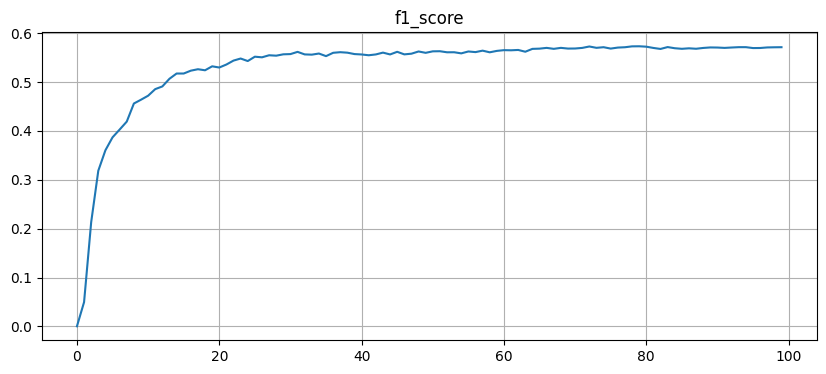

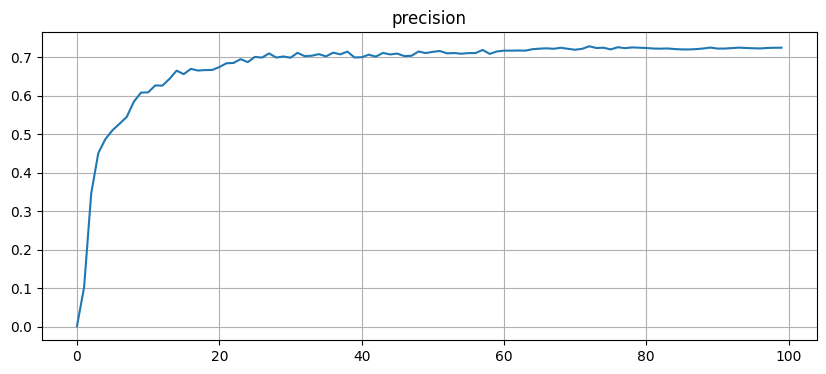

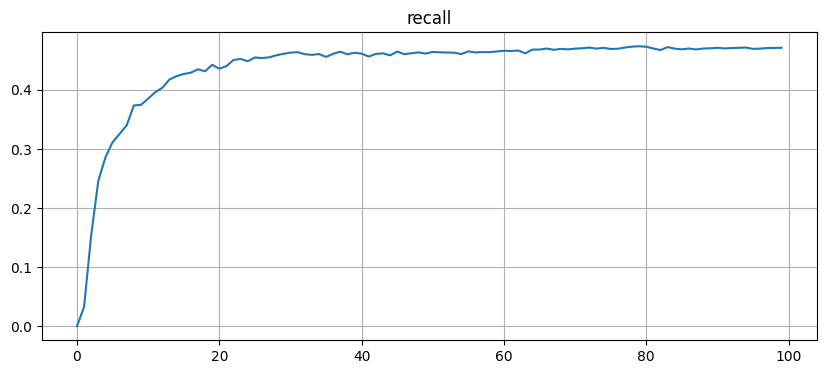

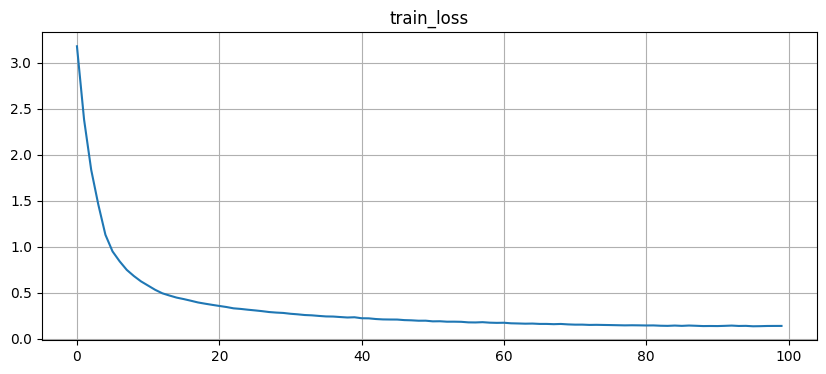

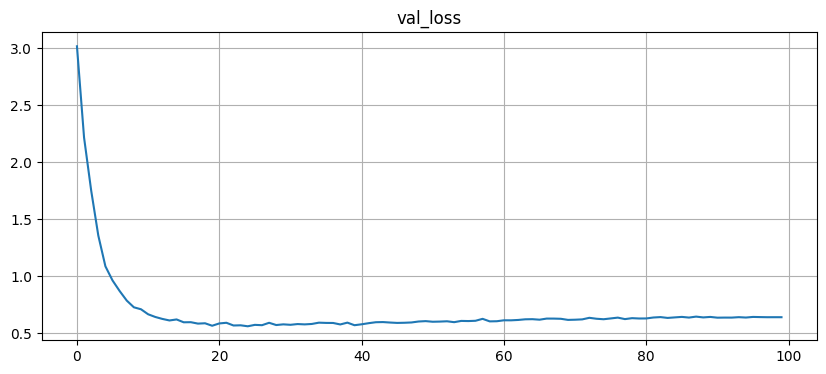

In [30]:
for i, (name, history) in enumerate (sorted (metrics.items ())):
    #plt.plot (1, len (metrics), i + 1)
    plt.figure (figsize = (10, 4))
    plt.title (name)
    plt.plot (*zip (*history))
    plt.grid ()
    plt.show ()

In [31]:


model.eval ()  # Устанавливаем модель в режим оценки
val_preds, val_labels = [], []

with torch.no_grad ():
    for batch in tqdm (val_loader):
        input_ids = batch ['input_ids'].to (model.device)
        attention_mask = batch ['attention_mask'].to (model.device)
        labels = batch ['labels'].to (model.device)
        out = model.generate (input_ids = input_ids, attention_mask = attention_mask)

        val_preds.extend (out)
        val_labels.extend (labels)
        torch.cuda.empty_cache ()

    print ('Validation: ', sanity_check (val_preds, val_labels))

'''
val_preds, val_labels = [], []

with torch.no_grad ():
    for batch in tqdm (test_loader):
        input_ids = batch ['input_ids'].to (model.device)
        attention_mask = batch ['attention_mask'].to (model.device)
        labels = batch ['labels'].to (model.device)
        out = model.generate (input_ids = input_ids, attention_mask = attention_mask)

        val_preds.extend (out)
        val_labels.extend (labels)

    print ('Test: ', sanity_check (val_preds, val_labels))
'''

100%|██████████| 81/81 [00:32<00:00,  2.52it/s]


Validation:  (0.7253758821724455, 0.4711979270480367, 0.5712904784920251)


"\nval_preds, val_labels = [], []\n\nwith torch.no_grad ():\n    for batch in tqdm (test_loader):\n        input_ids = batch ['input_ids'].to (model.device)\n        attention_mask = batch ['attention_mask'].to (model.device)\n        labels = batch ['labels'].to (model.device)\n        out = model.generate (input_ids = input_ids, attention_mask = attention_mask)\n\n        val_preds.extend (out)\n        val_labels.extend (labels)\n\n    print ('Test: ', sanity_check (val_preds, val_labels))\n"

In [36]:

val_preds, val_labels = [], []
with torch.no_grad ():
    for batch in tqdm (val_loader):
        input_ids = batch ['input_ids'].to (model.device)
        attention_mask = batch ['attention_mask'].to (model.device)
        labels = batch ['labels'].to (model.device)
        out = model.generate (input_ids = input_ids, attention_mask = attention_mask, max_length=SEQ_MAX_LENGTH)

        val_preds.extend (out)
        val_labels.extend (labels)
        torch.cuda.empty_cache ()

    print ('Validation wmax: ', sanity_check (val_preds, val_labels))

'''
val_preds, val_labels = [], []
with torch.no_grad ():
    for batch in tqdm (test_loader):
        input_ids = batch ['input_ids'].to (model.device)
        attention_mask = batch ['attention_mask'].to (model.device)
        labels = batch ['labels'].to (model.device)
        out = model.generate (input_ids = input_ids, attention_mask = attention_mask, max_length=SEQ_MAX_LENGTH)

        val_preds.extend (out)
        val_labels.extend (labels)

    print ('Test wmax: ', sanity_check (val_preds, val_labels))
'''

100%|██████████| 81/81 [00:35<00:00,  2.29it/s]


Validation wmax:  (0.7720481927710844, 0.6386286625473391, 0.6990291262135923)


"\nval_preds, val_labels = [], []\nwith torch.no_grad ():\n    for batch in tqdm (test_loader):\n        input_ids = batch ['input_ids'].to (model.device)\n        attention_mask = batch ['attention_mask'].to (model.device)\n        labels = batch ['labels'].to (model.device)\n        out = model.generate (input_ids = input_ids, attention_mask = attention_mask, max_length=SEQ_MAX_LENGTH)\n\n        val_preds.extend (out)\n        val_labels.extend (labels)\n\n    print ('Test wmax: ', sanity_check (val_preds, val_labels))\n"

In [33]:
#model.save_pretrained ('./rut5base_fulltrain_novalid_dictionary_postfix')
#tokenizer.save_pretrained ('./rut5base_fulltrain_novalid_dictionary_postfix')

('./rut5base_fulltrain_novalid_dictionary_postfix\\tokenizer_config.json',
 './rut5base_fulltrain_novalid_dictionary_postfix\\special_tokens_map.json',
 './rut5base_fulltrain_novalid_dictionary_postfix\\spiece.model',
 './rut5base_fulltrain_novalid_dictionary_postfix\\added_tokens.json',
 './rut5base_fulltrain_novalid_dictionary_postfix\\tokenizer.json')

In [34]:
print (parallel_text_val [6])
predicted_set = get_set (val_preds [6], ground_truth = False)
predicted_set

Результаты экспериментов приводятся и анализируются в статье в сравнении с результатами другими участниками РОМИП-2011.


{''}

In [35]:
print 4

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(...)? (928237153.py, line 1)

In [ ]:
model = MT5ForConditionalGeneration.from_pretrained ('./coint_rut5small_finetune_fulltrain_novalid')

model.to (device)
print (model.device)

In [ ]:
val_data = tokenizer (parallel_text_val_new, padding = 'max_length', truncation = True, max_length = SEQ_MAX_LENGTH, return_tensors = 'pt')
val_labels = tokenizer (parallel_label_val, padding = 'max_length', truncation = True, max_length = ANSWER_MAX_LENGTH, return_tensors = 'pt')

if ENABLE_LABEL_FIX:
    rse = replace_padding (val_labels)
    val_labels = rse

val_dataset = Seq2SeqDataset (val_data, val_labels)

val_loader = DataLoader (val_dataset, batch_size = EVAL_BATCH_SIZE)

In [ ]:
val_preds, val_labels = [], []
with torch.no_grad ():
    for batch in tqdm (val_loader):
        input_ids = batch ['input_ids'].to (model.device)
        attention_mask = batch ['attention_mask'].to (model.device)
        labels = batch ['labels'].to (model.device)
        out = model.generate (input_ids = input_ids, attention_mask = attention_mask, max_length=SEQ_MAX_LENGTH)

        val_preds.extend (out)
        val_labels.extend (labels)

    print ('Validation augmented: ', sanity_check (val_preds, val_labels))

In [50]:

parallel_text_val_augmented = []
for i in range (len (val_preds)):
    predicted_set = get_set (val_preds [i], ground_truth = False)
    parallel_text_val_augmented.append (make_attachment (parallel_text_val [i], predicted_set))

val_data = tokenizer (parallel_text_val_augmented, padding = 'max_length', truncation = True, max_length = SEQ_MAX_LENGTH, return_tensors = 'pt')
val_labels = tokenizer (parallel_label_val, padding = 'max_length', truncation = True, max_length = ANSWER_MAX_LENGTH, return_tensors = 'pt')

if ENABLE_LABEL_FIX:
    rse = replace_padding (val_labels)
    val_labels = rse

val_dataset = Seq2SeqDataset (val_data, val_labels)

val_loader = DataLoader (val_dataset, batch_size = EVAL_BATCH_SIZE)

In [51]:
val_preds, val_labels = [], []
with torch.no_grad ():
    for batch in tqdm (val_loader):
        input_ids = batch ['input_ids'].to (model.device)
        attention_mask = batch ['attention_mask'].to (model.device)
        labels = batch ['labels'].to (model.device)
        out = model.generate (input_ids = input_ids, attention_mask = attention_mask, max_length=SEQ_MAX_LENGTH)

        val_preds.extend (out)
        val_labels.extend (labels)
        torch.cuda.empty_cache ()

    print ('Validation augmented: ', sanity_check (val_preds, val_labels))

100%|██████████| 81/81 [00:51<00:00,  1.58it/s]


Validation augmented:  (0.6927557335274845, 0.7586206896551724, 0.7241937018361716)


In [45]:
prev_model = MT5ForConditionalGeneration.from_pretrained ('./coint_rut5small_finetune_fulltrain_novalid')

prev_model.to (device)
print (prev_model.device)

cuda:0


In [46]:

val_data = tokenizer (parallel_text_val, padding = 'max_length', truncation = True, max_length = 150, return_tensors = 'pt')
val_labels = tokenizer (parallel_label_val, padding = 'max_length', truncation = True, max_length = 150, return_tensors = 'pt')

if ENABLE_LABEL_FIX:
    rse = replace_padding (val_labels)
    val_labels = rse

val_dataset = Seq2SeqDataset (val_data, val_labels)

val_loader = DataLoader (val_dataset, batch_size = EVAL_BATCH_SIZE)

In [47]:
val_preds, val_labels = [], []
with torch.no_grad ():
    for batch in tqdm (val_loader):
        input_ids = batch ['input_ids'].to (prev_model.device)
        attention_mask = batch ['attention_mask'].to (prev_model.device)
        labels = batch ['labels'].to (prev_model.device)
        out = prev_model.generate (input_ids = input_ids, attention_mask = attention_mask, max_length=SEQ_MAX_LENGTH)

        val_preds.extend (out)
        val_labels.extend (labels)
        torch.cuda.empty_cache ()

    print ('Validation augmented: ', sanity_check (val_preds, val_labels))

100%|██████████| 81/81 [00:42<00:00,  1.91it/s]


Validation augmented:  (0.6950162513542795, 0.7673444976076556, 0.7293916998294486)


In [ ]:
#model.save_pretrained('./rut5small_fulltrain_novalid_dictionary_postfix')
#tokenizer.save_pretrained('./rut5small_fulltrain_novalid_dictionary_postfix')

In [ ]:
num_epochs = 20
training_steps = len (train_data ['input_ids']) // BATCH_SIZE * num_epochs
warmup_steps = int (training_steps * 0.1)
print (f'Suggested train steps: {training_steps}\n\t warmup steps: {int (training_steps * 0.05)} - {int (training_steps * 0.1)}')

In [ ]:
#optimizer = AdamW (model.parameters (), lr = 1e-5)#, weight_decay = 0.05)
optimizer = AdamW (filter (lambda p: p.requires_grad, model.parameters ()), lr = 5e-5, weight_decay = 0.01)

#optimizer = Adafactor (model.parameters (), lr = 3e-5, scale_parameter = False, relative_step = False, weight_decay = 0.02)

#scheduler = lr_scheduler.StepLR (optimizer, warmup_steps = 637, training_steps = 6375)
scheduler = get_scheduler ('linear', optimizer = optimizer, num_warmup_steps = warmup_steps, num_training_steps = training_steps)

In [ ]:
for epoch in range (num_epochs):
    model.train ()  # Устанавливаем модель в режим обучения
    total_loss = 0
    
    for batch in tqdm (val_loader):
        
        input_ids = batch ['input_ids'].to (model.device)
        attention_mask = batch ['attention_mask'].to (model.device)
        labels = batch ['labels'].to (model.device)

        outputs = model (input_ids = input_ids, attention_mask = attention_mask, labels = labels)
        loss = outputs.loss   ## DOUBLE CHECK if padding ...
        total_loss += loss.item ()

        loss.backward ()  # Обратное распространение
        optimizer.step ()  # Обновление параметров
        optimizer.zero_grad ()  # Обнуляем градиенты

        scheduler.step ()  # Обновление learning rate
    

    avg_loss = total_loss / len (train_loader)

    metrics ['train_loss'].append ((epoch, avg_loss))

    # Оценка на валидационной выборке
    model.eval ()  # Устанавливаем модель в режим оценки
    val_preds, val_labels = [], []
    total_val_loss = 0

    with torch.no_grad ():
        for batch in val_loader:
            input_ids = batch ['input_ids'].to (model.device)
            attention_mask = batch ['attention_mask'].to (model.device)
            labels = batch ['labels'].to (model.device)

            outputs = model.generate (input_ids = input_ids, attention_mask = attention_mask)

            total_val_loss += model (input_ids = input_ids, attention_mask = attention_mask, labels = labels).loss.item ()

            val_preds.extend (outputs)
            val_labels.extend (labels)

    avg_val_loss = total_val_loss / len (val_loader)

    prec, recl, f1sc = sanity_check (val_preds, val_labels)

    metrics ['val_loss'].append ((epoch, avg_val_loss))
    metrics ['precision'].append ((epoch, prec))
    metrics ['recall'].append ((epoch, recl))
    metrics ['f1_score'].append ((epoch, f1sc))

    print (f'Epoch {epoch + 1} / {num_epochs}, Loss: {avg_loss:.4f}, Validation loss: {avg_val_loss:.4f}, {prec} / {recl} / {f1sc}')

In [ ]:
#model.save_pretrained('./rut5small_fulltrain_plusvalid')
#tokenizer.save_pretrained('./rut5small_fulltrain_plusvalid')